In [1]:
import pyfesom2 as pf
import xarray as xr
import os
import pandas as pd
from collections import OrderedDict
from itertools import product
import matplotlib.pylab as plt
import numpy as np
from matplotlib import cm
%matplotlib inline
import math

In [17]:
# parameters cell
meshpath = "/Users/nkolduno/PYTHON/DATA/core2_meanz_mesh/"
abg = [50, 15, -90]
variable = 'temp'
input_paths = [
    "/Users/nkolduno/PYTHON/DATA/output_7_8/",
    "/Users/nkolduno/PYTHON/DATA/output_7_10",
]
input_names = ['control', 'opt1']
years = range(1978, 1986)
reference_path = '/Users/nkolduno/PYTHON/DATA/CLIM_on_mesh/core2_meanz/'
reference_name = 'clim'
reference_years = 1948
figsize=[24, 14]
maxdepth = 3000
units = r'$^\circ$C'
ncols=3
dpi = 200
ofile = None
regions = ["Global Ocean", "Atlantic_Basin", "Pacific_Basin", "Indian_Basin", "Southern_Ocean_Basin", "Arctic_Basin",]
cached_path = None
# Available regions:
#         Ocean Basins:
#             "Atlantic_Basin"
#             "Pacific_Basin"
#             "Indian_Basin"
#             "Arctic_Basin"
#             "Southern_Ocean_Basin"
#             "Mediterranean_Basin"
#             "Global Ocean"
#             "Global Ocean 65N to 65S"
#             "Global Ocean 15S to 15N"
#         MOC Basins:
#             "Atlantic_MOC"
#             "IndoPacific_MOC"
#             "Pacific_MOC"
#             "Indian_MOC"
#         Nino Regions:
#             "Nino 3.4"
#             "Nino 3"
#             "Nino 4"
#         Arctic Ocean regions:
#             "Amerasian basin"
#             "Eurasian basin"

In [18]:
if input_names is None:
    input_names = []
    for run in input_paths:
        run = os.path.join(run, '')
        input_names.append(run.split('/')[-2])

In [19]:
mesh = pf.load_mesh(meshpath, abg=abg, 
                    usepickle=True, usejoblib=False)

/Users/nkolduno/PYTHON/DATA/core2_meanz_mesh/pickle_mesh_py3_fesom2
The usepickle == True)
The pickle file for FESOM2 exists.
The mesh will be loaded from /Users/nkolduno/PYTHON/DATA/core2_meanz_mesh/pickle_mesh_py3_fesom2


In [22]:
def get_data_cache(cached_path,
                   exp_name,
                   exp_path,
                   variable,
                   years,
                   mesh,
                   depth=None, 
                   how='mean',
                   compute=True,
                   silent=True):
    
    if cached_path is None:
        cached_path = exp_path
    
    if depth is None:
        depth_cache = '3d'
    else:
        depth_cache = depth
        
    if how is None:
        how_cache = "timeseries"
    else:
        how_cache = "how"
        
    if cached_path is False:
        data_out = pf.get_data(exp_path,
                               variable,
                               years,
                               mesh,
                               depth = depth,
                               how=how,
                               compute=compute,
                               silent=silent)
        return data_out
    
    else:
        if not isinstance(years, (list, np.ndarray, range)):
            years_str = [years]
        else:
            years_str = years
        print(years_str)
        cached_file = f"{cached_path}/{exp_name}_{variable}_{years_str[0]}_{years_str[-1]}_{depth_cache}_{how_cache}.nc"
        print(cached_file)
        if os.path.exists(cached_file):
            print('use cached')
            data_out = xr.open_dataset(cached_file)
            data_out = data_out[variable]
        else:
            print('compute')
            data_out = pf.get_data(exp_path,
                               variable,
                               years,
                               mesh,
                               depth = depth,
                               how=how,
                               compute=False,
                               silent=silent)
            data_out.to_netcdf(cached_file)
    if compute:
        data_out = data_out.compute()
        data_out = data_out.data
                
    return data_out

In [21]:
hofm = OrderedDict()
hofm['means'] = {}
hofm['regions'] = {}

hofm['means'][reference_name] = {}
data_reference = get_data_cache(cached_path, reference_name, reference_path, variable, reference_years, mesh, how=None, silent=True, compute=False)
hofm['means'][reference_name]['data'] = data_reference
for exp_path, exp_name  in zip(input_paths, input_names):
    data = pf.get_data(exp_path, variable, years, mesh, how='mean', compute=False, silent=True)
    hofm['means'][exp_name] = {}
#     data_difference= pf.hovm_data(data, mesh, mask = mask) - hofm_reference.data
#     hofm[title]['data_differene'] = data_difference
    hofm['means'][exp_name]['data'] = data

for region in regions:
    mask = pf.get_mask(mesh, region)
    hofm['regions'][region] = {}
    hofm_reference = pf.hovm_data(hofm['means'][reference_name]['data'], mesh, mask = mask)
    hofm['regions'][region][reference_name] = {}
    hofm['regions'][region][reference_name]['data'] = hofm_reference
    hofm['regions'][region][reference_name]['data_differene'] = None
    hofm['regions'][region][reference_name]['nodiff'] = True
    for exp_path, exp_name  in zip(input_paths, input_names):
#         data = pf.get_data(exp_path, variable, years, mesh, how='mean', compute=False, silent=True)
#         title = exp_name+" - "+reference_name
        hofm['regions'][region][exp_name] = {}
        data_experiment = pf.hovm_data(hofm['means'][exp_name]['data'], mesh, mask = mask)
        data_difference= data_experiment - hofm['regions'][region][reference_name]['data'].data
        hofm['regions'][region][exp_name]['data_differene'] = data_difference
        hofm['regions'][region][exp_name]['data'] = data_experiment
        if (data_difference.max() == data_difference.min() == 0):
            hofm['regions'][region][exp_name]['nodiff'] = True
        else:
            hofm['regions'][region][exp_name]['nodiff'] = False
#         del data
        print(exp_name)

[1948]
/Users/nkolduno/PYTHON/DATA/CLIM_on_mesh/core2_meanz//clim_temp_1948_1948_3d_None.nc
use cached


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


control


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


opt1


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


control


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


opt1


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


control


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


opt1


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


control


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


opt1


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


control


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


opt1


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


control
opt1


/Users/nkolduno/miniconda3/envs/pyfesom2/lib/python3.8/site-packages/dask/core.py:121: RuntimeWarning: invalid value encountered in true_divide
  return func(*(_execute_task(a, cache) for a in args))


In [6]:
hofm['regions'].keys()

dict_keys(['Global Ocean', 'Atlantic_Basin', 'Pacific_Basin', 'Indian_Basin', 'Southern_Ocean_Basin', 'Arctic_Basin'])

In [7]:
def data_to_plot_for_diff(hofm, region):
    plot_data = []
    plot_names = []
    for key, value in hofm['regions'][region].items():
#         print(key)
        if value['nodiff'] is False:
            plot_data.append(value['data_differene'])
            plot_names.append(key+" - "+reference_name)
                
    return plot_data, plot_names

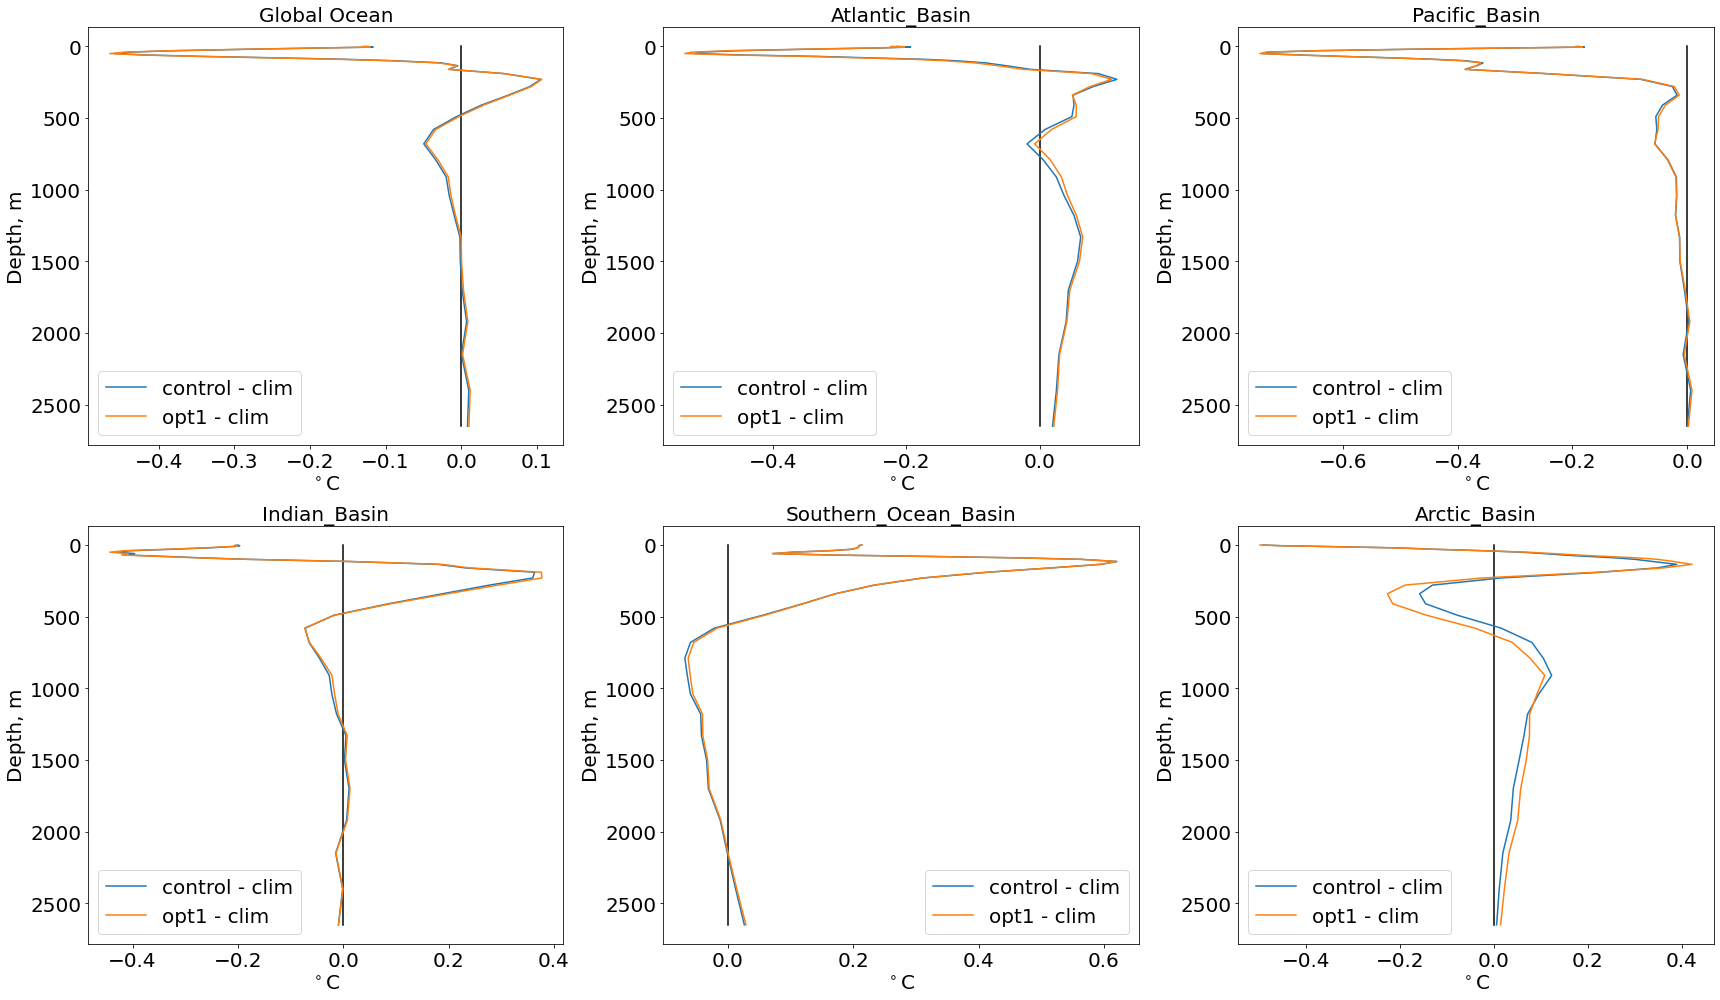

In [8]:
ncols = float(ncols)
nplots = len(regions)
nrows = math.ceil(nplots / ncols)
ncols = int(ncols)
nrows = int(nrows)
fontsize=20
depth_index = pf.ind_for_depth(maxdepth, mesh)
if not figsize:
    figsize = (8 * ncols, 2 * nrows * ncols)
fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
ax = ax.flatten()
ind = 0

for region in regions:
    plot_data, plot_names = data_to_plot_for_diff(hofm, region)
    ax[ind].plot(np.zeros(len(mesh.zlev[:depth_index])), np.abs(mesh.zlev[:depth_index]), color='k')
    n = 0
    for data, names in zip(plot_data, plot_names):
        if n<10:
            image = ax[ind].plot(data[0,:depth_index], np.abs(mesh.zlev[:depth_index]), label=names, linestyle='-')
        else:
            image = ax[ind].plot(data[0,:depth_index], np.abs(mesh.zlev[:depth_index]), label=names, linestyle='--')
        n = n+1
    ax[ind].legend(prop={'size': fontsize});
    ax[ind].invert_yaxis()
    ax[ind].set_title(region, size=fontsize)
    ax[ind].set_xlabel(units, size=fontsize)
    ax[ind].set_ylabel("Depth, m", size=fontsize)
    ax[ind].tick_params(axis="both", which="major", labelsize=fontsize)
    ind=ind+1

for delind in range(ind, len(ax)):
    fig.delaxes(ax[delind])

fig.tight_layout()
if ofile is not None:
    ofile_long = f"{ofile}_difference.png"
    plt.savefig(ofile_long, dpi=dpi)
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')

In [9]:
def data_to_plot(hofm, region):
    plot_data = []
    plot_names = []
    for key, value in hofm['regions'][region].items():
#         print(key)
#         if value['nodiff'] is False:
        plot_data.append(value['data'])
        plot_names.append(key)
                
    return plot_data, plot_names

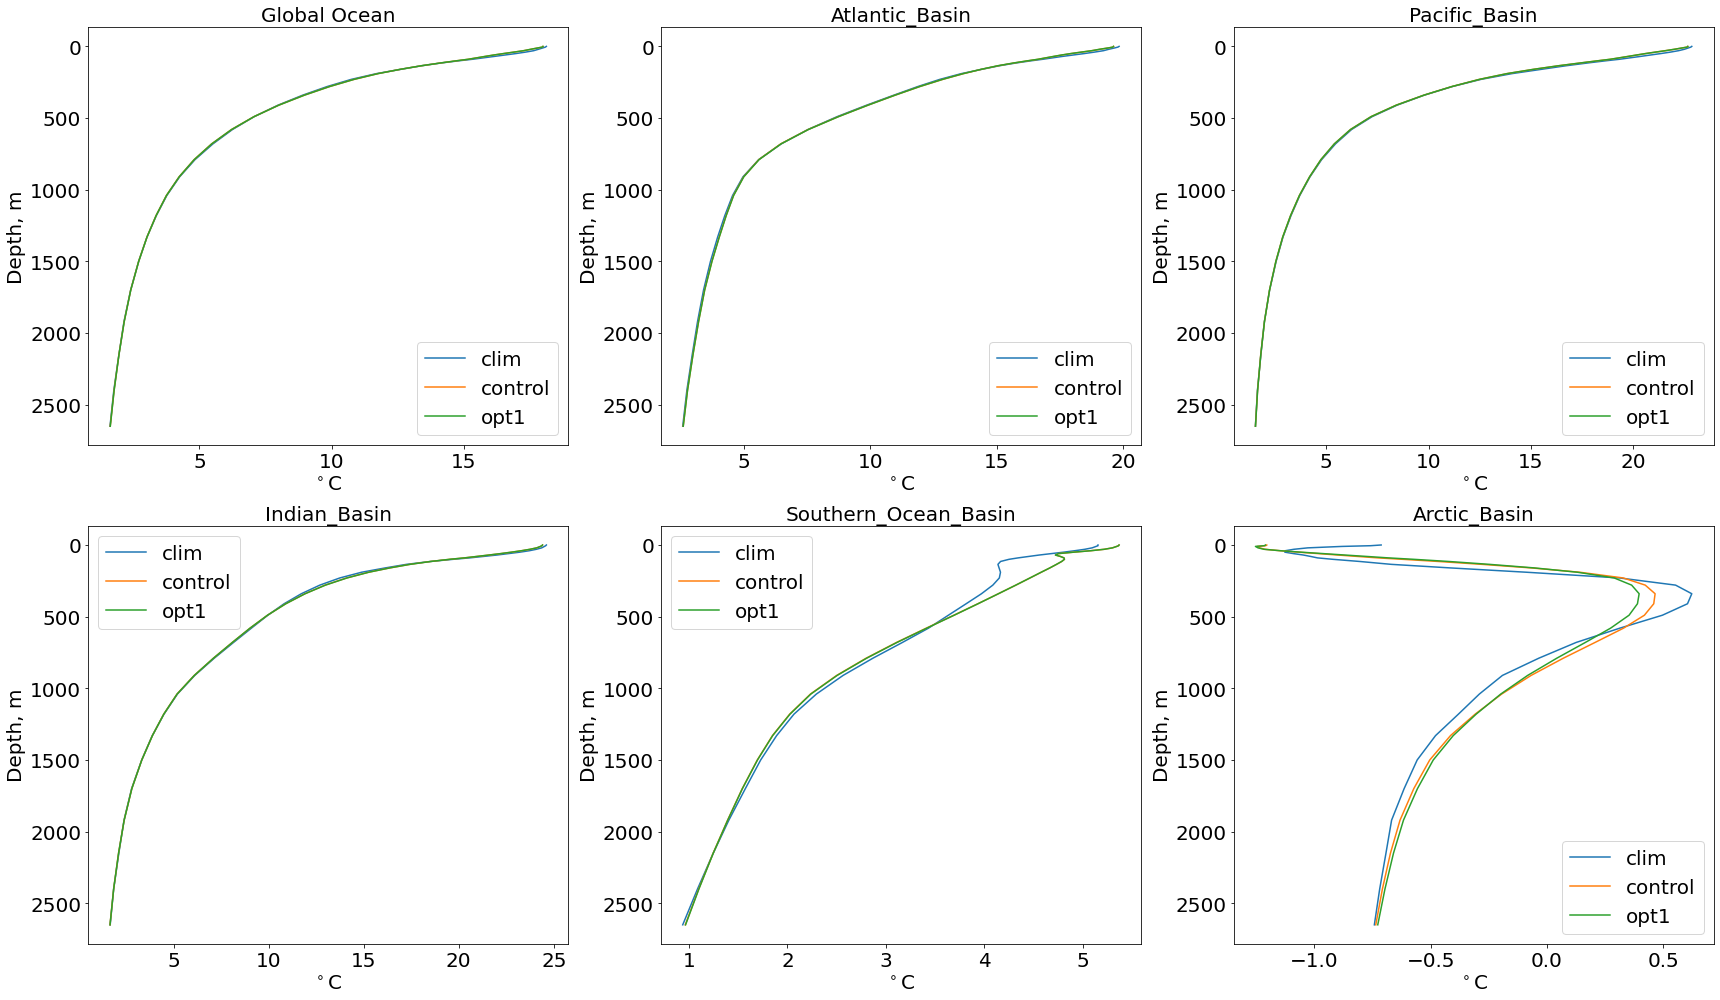

In [10]:
ncols = float(ncols)
nplots = len(regions)
nrows = math.ceil(nplots / ncols)
ncols = int(ncols)
nrows = int(nrows)
fontsize=20
depth_index = pf.ind_for_depth(maxdepth, mesh)
if not figsize:
    figsize = (8 * ncols, 2 * nrows * ncols)
fig, ax = plt.subplots(nrows, ncols, figsize=figsize)
ax = ax.flatten()
ind = 0

for region in regions:
    plot_data, plot_names = data_to_plot(hofm, region)
    n = 0
    for data, names in zip(plot_data, plot_names):
        if n<10:
            image = ax[ind].plot(data[0,:depth_index], np.abs(mesh.zlev[:depth_index]), label=names, linestyle='-')
        else:
            image = ax[ind].plot(data[0,:depth_index], np.abs(mesh.zlev[:depth_index]), label=names, linestyle='--')
        
    ax[ind].legend(prop={'size': fontsize});
    ax[ind].invert_yaxis()
    ax[ind].set_title(region, size=fontsize)
    ax[ind].set_xlabel(units, size=fontsize)
    ax[ind].set_ylabel("Depth, m", size=fontsize)
    ax[ind].tick_params(axis="both", which="major", labelsize=fontsize)
    ind=ind+1

for delind in range(ind, len(ax)):
    fig.delaxes(ax[delind])

fig.tight_layout()
if ofile is not None:
    ofile_long = f"{ofile}_absolute.png"
    plt.savefig(ofile_long)
    os.system(f'convert {ofile_long} -trim {ofile_long}_trimmed.png')
    os.system(f'mv {ofile_long}_trimmed.png {ofile_long}')